In [3]:
import tensorflow as tf
import os
import pandas as pd
import zipfile
import shutil
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [4]:
#current_directory = os.getcwd()

# this variable should be changed after making .py files
current_directory = '/content/drive/MyDrive/Build a Deep CNN Image Classifier\
 with ANY Images/GithubRepo/StopSignClassification'
os.chdir(current_directory)

raw_datas_path=os.path.join(current_directory, 'rawDatas')
print(raw_datas_path)

# Avoiding OOM
gpus= tf.config.experimental.list_physical_devices('GPU')
#gpus= tf.config.experimental.list_physical_devices('CPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print(gpus)

/content/drive/MyDrive/Build a Deep CNN Image Classifier with ANY Images/GithubRepo/StopSignClassification/rawDatas
[]


In [5]:
gpus= tf.config.experimental.list_physical_devices('GPU')
image_exts=['jpeg','jpg','bmp','png']
classes_names_df=pd.read_csv(os.path.join(raw_datas_path,'labels.csv'))
# we only use two classes for this project
#classes_names_df=classes_names_df.iloc[[16,29]]
class_ids=classes_names_df.iloc[:,0].tolist()
classes_names=classes_names_df.iloc[:,1].tolist()

batch_size=16
image_size=(64,64)

datas=tf.keras.utils.image_dataset_from_directory(os.path.join(raw_datas_path,'traffic_Data','DATA'), batch_size=batch_size, image_size=image_size)
datas=datas.map(lambda x,y:(x/255,y))
datas_iterator=datas.as_numpy_iterator()

Found 4170 files belonging to 58 classes.


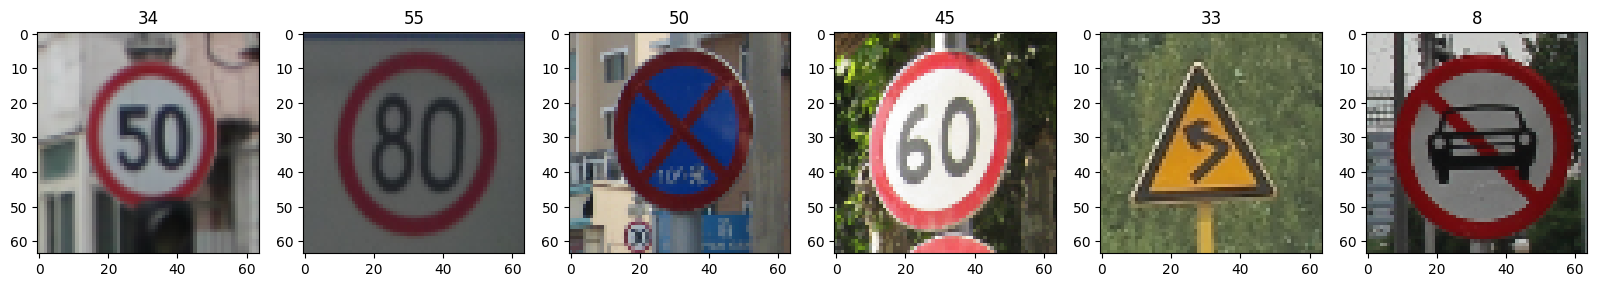

In [6]:
test_batch=datas_iterator.next()
fig, ax=plt.subplots(ncols=6, figsize=(20,20))
for idx, img in enumerate(test_batch[0][0:6]*255):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(test_batch[1][idx])

In [7]:
# len(datas) returns number of batchs
train_size=int(0.7*len(datas))
test_size=int(0.1*len(datas))
validation_size=len(datas)-train_size-test_size

train_datas=datas.take(train_size)
test_datas=datas.skip(train_size).take(test_size)
validation_datas=datas.skip(train_size + test_size).take(validation_size)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=image_size+(3,)))
model.add(MaxPool2D())

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(58, activation='sigmoid'))

In [9]:
model.compile('adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 16)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 15376)             0         
                                                                 
 dense (Dense)               (None, 128)               1968256   
                                                                 
 dense_1 (Dense)             (None, 58)                7482      
                                                                 
Total params: 1976186 (7.54 MB)
Trainable params: 1976186 (7.54 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [10]:
logdir='logs'
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=current_directory+logdir)

In [ ]:
hist = model.fit(train_datas, epochs=10, validation_data=validation_datas, callbacks=[tensorboard_callback])

Epoch 1/10
182/182 [==============================] - 758s 4s/step - loss: 2.4707 - accuracy: 0.4502 - val_loss: 1.3409 - val_accuracy: 0.7078
Epoch 2/10
182/182 [==============================] - 40s 218ms/step - loss: 0.8424 - accuracy: 0.8152 - val_loss: 0.6159 - val_accuracy: 0.8634
Epoch 3/10
182/182 [==============================] - 38s 205ms/step - loss: 0.3624 - accuracy: 0.9224 - val_loss: 0.3650 - val_accuracy: 0.9299
Epoch 4/10
182/182 [==============================] - 40s 213ms/step - loss: 0.1740 - accuracy: 0.9701 - val_loss: 0.2201 - val_accuracy: 0.9632
Epoch 5/10
182/182 [==============================] - 39s 211ms/step - loss: 0.0843 - accuracy: 0.9852 - val_loss: 0.1993 - val_accuracy: 0.9608
Epoch 6/10
182/182 [==============================] - 43s 235ms/step - loss: 0.0423 - accuracy: 0.9948 - val_loss: 0.1827 - val_accuracy: 0.9656
Epoch 7/10
182/182 [==============================] - 38s 207ms/step - loss: 0.0345 - accuracy: 0.9973 - val_loss: 0.1406 - val_accu

In [ ]:
model.save(os.path.join(current_directory, 'stopSignSegmentation.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
model = tf.keras.models.load_model(os.path.join(current_directory, 'stopSignSegmentation.h5'))

In [12]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

NameError: name 'hist' is not defined

<Figure size 640x480 with 0 Axes>

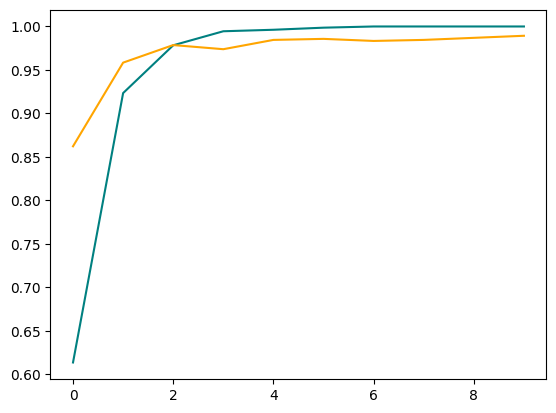

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')

In [1]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test_datas.as_numpy_iterator():
  X, y = batch
  y = tf.keras.utils.to_categorical(y, 58)
  yhat = model.predict(X)
  max_index = np.argmax(yhat, axis=1)
  yhat = tf.keras.utils.to_categorical(max_index, 58)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

NameError: name 'test_datas' is not defined

In [ ]:
test_batch=datas_iterator.next()
fig, ax=plt.subplots(ncols=6, figsize=(20,20))
#fig.suptitle('y')
for idx, img in enumerate(test_batch[0][0:6]*255):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(f'Real: {test_batch[1][idx]}')

test_batch_yhat=np.argmax(model.predict(test_batch[0]), axis=1)
fig2, ax2=plt.subplots(ncols=6, figsize=(20,20))
for idx, img in enumerate(test_batch[0][0:6]*255):
  ax2[idx].imshow(img.astype(int))
  ax2[idx].title.set_text(f'Estimated: {test_batch_yhat[idx]}')